In [1]:
import jax
import jax.numpy as jnp
import sys
from jax import random

sys.path.append('/Users/dashiell/workspace/simplex-score-matching/src')

from ssm.simplex_proj import vector_simplex_proj
from ssm.visualize_simplex import rotate_simplex_to_xy
import ssm.aitchison as aitch


key = random.PRNGKey(42)



/Users/dashiell/miniconda3/envs/ssm/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
def make_p_with_conc(concentration, size, key):
    dir0 = jax.random.dirichlet(key, jnp.ones((size-1,))) * (1 - concentration)
    x = jnp.array([concentration])
    return jnp.append(x, dir0)


key, subkey = jax.random.split(key)

x0 = make_p_with_conc(.95, 25, subkey)
jax.nn.softmax(aitch.clr(x0)).shape

(25,)

In [3]:
from ssm.utils import t_to_alpha_sigma


def add_noise(concentration, time, dim, num_samples, key):
    keys = jax.random.split(key, 4)
    x0 = make_p_with_conc(concentration, dim, keys[0])
    alpha, sigma = 1., time * 10
    raw_noise = jax.random.normal(keys[1], (num_samples, dim))
    x = aitch.clr(x0)
    simplex_scaled_noise = aitch.simplex_metric_tensor_inv(
        jnp.tile(x0, (num_samples, 1)),
        raw_noise
    )
    new_x = alpha * x + sigma * simplex_scaled_noise
    return new_x - jnp.mean(new_x, axis=-1, keepdims=True)


key, subkey = jax.random.split(key)


noised_samples = add_noise(0.9, 0.4, 3, 10_000, subkey) 

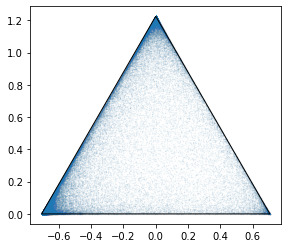

<Figure size 720x720 with 0 Axes>

In [128]:
import numpy as np
import matplotlib.pyplot as plt

key, subkey = jax.random.split(key)

sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
noised_samples = add_noise(0.8, 0.9, 3, 100_000, subkey) 
plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(jax.nn.softmax(noised_samples))
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.01)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

In [120]:
p = jnp.array([.95, .02, 0.03])
sfm_jac = jax.jacobian(jax.nn.softmax)(p)
print(aitch.clr(p))
print('###################')
print(sfm_jac)

[ 2.438665  -1.4220648 -1.0165997]
###################
[[ 0.24667051 -0.12271859 -0.12395193]
 [-0.12271859  0.17162429 -0.04890569]
 [-0.12395193 -0.04890569  0.17285763]]


In [75]:
t_to_alpha_sigma(.9)

(DeviceArray(0.15643449, dtype=float32, weak_type=True),
 DeviceArray(0.98768836, dtype=float32, weak_type=True))

In [46]:
def print_summaries(a):
    minval = jnp.min(a, axis=0)
    maxval = jnp.max(a, axis=0)
    meanval = jnp.mean(a, axis=0)
    print(f'Min: {minval.tolist()}')
    print(f'Max: {maxval.tolist()}')
    print(f'Mean: {meanval.tolist()}')
    
    
def examine_transform_at(p, num_samples):
    dim = p.size
    noise = jax.random.normal(subkey, shape=(num_samples, dim))
    ginv_noise = aitch.simplex_metric_tensor_inv(
        jnp.tile(p, (num_samples, 1)),
        noise
    )
    print('Random normal')
    print_summaries(noise)
    print('Transformed normal')
    print_summaries(ginv_noise)
    
    
examine_transform_at(jnp.array([.6, .24, .16]), 100000) 

Random normal
Min: [-4.098713397979736, -4.231764316558838, -4.525681972503662]
Max: [4.2789740562438965, 4.413049697875977, 4.051164627075195]
Mean: [-0.006863041780889034, 0.00014026230201125145, -0.00036196113796904683]
Transformed normal
Min: [-1.284298062324524, -1.11815345287323, -1.069938063621521]
Max: [1.3033860921859741, 1.0824934244155884, 1.040380835533142]
Mean: [-0.0016545592807233334, 0.0009321769466623664, 0.0007223821594379842]


In [128]:
def v(p, alpha):
    return   ((alpha * jnp.log(p))**2).sum()

alpha = jnp.ones((3,))
p0 = jnp.array([1/3, 1/3, 1/3])
p1 = jnp.array([0.9, 0.05, 0.05])
p2 = jnp.array([0.9, 0.01, 0.09])
print(f'{p0}: {v(p0, alpha)}')
print(f'{p1}: {v(p1, alpha)}')
print(f'{p2}: {v(p2, alpha)}')

[0.33333334 0.33333334 0.33333334]: 3.62084698677063
[0.9  0.05 0.05]: 17.959924697875977
[0.9  0.01 0.09]: 27.016897201538086


In [4]:
def v(p):
    alpha = jnp.ones((p.shape[-1],))
    return ((alpha * jnp.log(p))**2).sum()


def potential(x):
    p = jax.nn.softmax(x)
    return aitch.simplex_metric_tensor_inv(
        p,
        jax.grad(v)(p)
    )

print(f'{p0}: {potential(p0)}')
print(f'{p1}: {potential(p1)}')
print(f'{p2}: {potential(p2)}')

NameError: name 'p0' is not defined

In [6]:
jnp.full((4, 4), 5)

DeviceArray([[5, 5, 5, 5],
             [5, 5, 5, 5],
             [5, 5, 5, 5],
             [5, 5, 5, 5]], dtype=int32, weak_type=True)

In [15]:
from functools import partial


def get_noise_schedule(sigma_min, sigma_max, num_steps):
    spaces = jnp.linspace(0., 1., num_steps)
    levels = sigma_min + (sigma_max - sigma_min) * jnp.linspace(0., 1., num_steps)
    return levels


def maybe_permute(key1, key2, dim):
    default = jnp.arange(dim)
    permutation = jax.random.choice(key1, dim, (dim,), replace=False)
    rand_num = jax.random.choice(key2, 2, (1,))
    return rand_num * default + (1 - rand_num) * permutation
    

def make_payoff_matrix(alphas):
    asum = jnp.sum(alphas)
    fill_val = asum + 1
    diag = jnp.diag(jnp.ones_like(alphas))
    full = jnp.full_like(diag, fill_val) - (diag * asum)
    return full
    
    
def do_sde(x0, num_steps, key):
    #ilr, ilr_inv = aitch.make_isometric_transforms(x.shape[-1])
    #x0 = ilr(x)
    min_noise, max_noise = 0.5, 5
    #key, *subkeys1 = jax.random.split(key, num_steps + 1)
    #key, *subkeys2 = jax.random.split(key, num_steps + 1)
    noise = jax.random.normal(key, (num_steps, x0.shape[-1]))
    # schedule = get_noise_schedule(min_noise, max_noise, num_steps)
    #noise = noise * schedule[...,None]
    alphas = jnp.ones((x0.shape[-1],))
    alpha_total = alphas.sum()
    payoff = make_payoff_matrix(alphas)
    delta_t = 1 / num_steps
    def sde_step(x, noise):
        # noise, sigma = noise_things
        g_inv = partial(aitch.simplex_metric_tensor_inv, jax.nn.softmax(x))
        scaled_noise = g_inv(noise)
        # new_inds = maybe_permute(key1, key2, x.shape[-1])
        drift = g_inv(jnp.matmul(payoff, alpha_total * x - alphas))
        #full_sigma = jnp.sqrt(delta_t) * noise
        new_x = x - (drift * delta_t) + (2 * jnp.sqrt(delta_t) * noise)
        return new_x, new_x
    final_loc, path = jax.lax.scan(
        sde_step,
        x0,
        noise
    )
    return path


In [16]:
num_gens = 100_000
key, *subkeys = jax.random.split(key, num_gens + 1)
ilr, ilr_inv = aitch.make_isometric_transforms(3)
x0 = aitch.clr(jnp.array([0.9, 0.03, 0.07]))
path = jax.vmap(do_sde, in_axes=(None, None, 0))(x0, 1000, jnp.stack(subkeys))

In [281]:
x = ilr(x0)
aitch.clr(3 * ilr_inv(x) - jnp.ones((3,)))

DeviceArray([nan, nan, nan], dtype=float32)

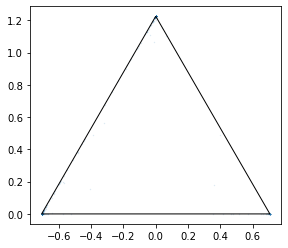

<Figure size 720x720 with 0 Axes>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
plt.figure()
X = jax.vmap(rotate_simplex_to_xy)(jax.nn.softmax(path[:, 999, :]))
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

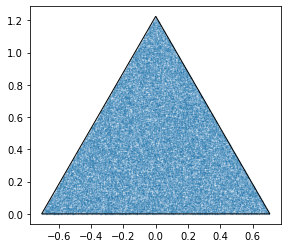

<Figure size 720x720 with 0 Axes>

In [210]:
import numpy as np
import matplotlib.pyplot as plt

key, subkey = jax.random.split(key)

sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])
samples = jax.random.dirichlet(subkey, jnp.ones((3,)), (100_000,))
plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(samples)
plt.scatter(X[:,0], X[:,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()                 

In [2]:
! pip3 install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 839.9 kB/s eta 0:00:00m eta 0:00:010:00:01


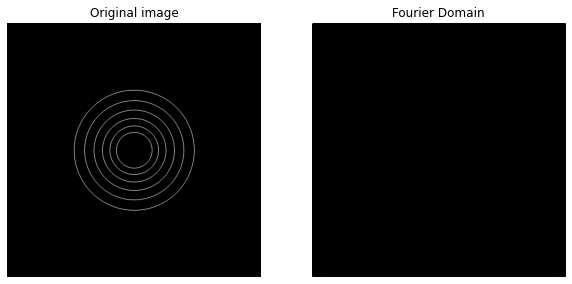

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import (line, polygon, disk,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)
from skimage.draw import line_aa, circle_perimeter_aa

from numpy import fft

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))


img = np.zeros((512, 512), dtype=np.double)
"""
# draw line
rr, cc = line(120, 123, 20, 400)
img[rr, cc, 0] = 255

# fill polygon
poly = np.array((
    (300, 300),
    (480, 320),
    (380, 430),
    (220, 590),
    (300, 300),
))
rr, cc = polygon(poly[:, 0], poly[:, 1], img.shape)
img[rr, cc, 1] = 1

# fill circle
rr, cc = disk((200, 200), 100, shape=img.shape)
img[rr, cc, :] = (1, 1, 0)

# fill ellipse
rr, cc = ellipse(300, 300, 100, 200, img.shape)
img[rr, cc, 2] = 1

"""

# circle
for i in range(4, 10):
    rr, cc, val = circle_perimeter_aa(256, 256, (i + 2)**2)
    img[rr, cc] = val

# Bezier curve
#rr, cc = bezier_curve(70, 100, 10, 10, 150, 100, 1)
#img[rr, cc, :] = (1, 0, 0)

"""
# ellipses
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=math.pi / 4.)
img[rr, cc, :] = (1, 0, 1)
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=-math.pi / 4.)
img[rr, cc, :] = (0, 0, 1)
rr, cc = ellipse_perimeter(120, 400, 60, 20, orientation=math.pi / 2.)
img[rr, cc, :] = (1, 1, 1)
"""
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Original image')
ax1.axis('off')


from skimage.draw import line_aa, circle_perimeter_aa


#img = np.zeros((100, 100), dtype=np.double)
fft_image = fft.fft2(img)

# anti-aliased line
#rr, cc, val = line_aa(12, 12, 20, 50)
#img[rr, cc] = val

# anti-aliased circle
#rr, cc, val = circle_perimeter_aa(60, 40, 30)
#img[rr, cc] = val


ax2.imshow(np.real(fft_image * np.conj(fft_image)), cmap=plt.cm.gray)
ax2.set_title('Fourier Domain')
ax2.axis('off')

plt.show()

In [37]:
x = np.linspace(0.0001, .9999, 100)
y = np.linspace(0.0001, .9999, 100)
xv, yv = np.meshgrid(x, y)
zv = 1 - xv - yv
zv[80]

def potential(x, y, z):
    s = np.log(x) + np.log(y) + np.log(z)
    return -1. * s

zv

array([[ 9.99800000e-01,  9.89701010e-01,  9.79602020e-01, ...,
         2.01979798e-02,  1.00989899e-02, -1.10182046e-17],
       [ 9.89701010e-01,  9.79602020e-01,  9.69503030e-01, ...,
         1.00989899e-02,  3.12250226e-17, -1.00989899e-02],
       [ 9.79602020e-01,  9.69503030e-01,  9.59404040e-01, ...,
        -3.81639165e-17, -1.00989899e-02, -2.01979798e-02],
       ...,
       [ 2.01979798e-02,  1.00989899e-02,  0.00000000e+00, ...,
        -9.59404040e-01, -9.69503030e-01, -9.79602020e-01],
       [ 1.00989899e-02,  0.00000000e+00, -1.00989899e-02, ...,
        -9.69503030e-01, -9.79602020e-01, -9.89701010e-01],
       [ 0.00000000e+00, -1.00989899e-02, -2.01979798e-02, ...,
        -9.79602020e-01, -9.89701010e-01, -9.99800000e-01]])

In [299]:
import numpy as np
import numpy.fft as fft

fft.fftn(np.linspace(0.1, 100, 1000).reshape(10, 10, 10)).shape

(10, 10, 10)

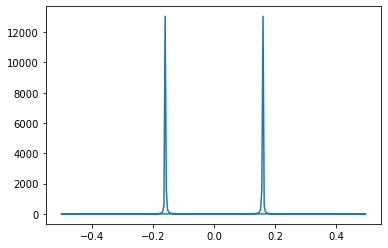

In [316]:
import matplotlib.pyplot as plt
theta = np.linspace(0, 1, 1000) 8 2 * np.pi
sin = np.sin(t)
sp = np.fft.fft(sin)
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, np.real(sp * np.conj(sp)))
plt.show()

In [314]:
np.real(sp[1] * np.conj(sp[1]))

2.1086969933426603

In [81]:

from ssm.utils import t_to_alpha_sigma



key = jax.random.PRNGKey(52)
dt = 1 / 100
rand_increments = jax.random.normal(key, (100, 2))*jnp.sqrt(dt)
simp_increments = jax.vmap(ilr_inv2)(rand_increments)


"""
def make_sde(alpha: float, gamma: float, dt: float):
    
    def _sde(xt, noise):
        g_inv = riemann_inv_metric(xt)
        rescaled_noise = clr_inv(jnp.matmul(g_inv, noise))
        x_ou = apow(
            perturb(gamma, apow(xt, -1.)),
            alpha * dt
        )
        new_loc = perturb(xt, perturb(x_ou, rescaled_noise))
        return new_loc, new_loc
    
    return _sde
"""




def make_sde(alpha, gamma, dt):
    gamma_rn = clr(gamma)
    def _sde(xt, noise):
        #g_inv = riemann_inv_metric(xt)
        #rescaled_noise = clr_inv(jnp.matmul(g_inv, noise))
        x_ou = alpha * dt * (gamma_rn - clr(xt))
        #x_ou = apow(
        #    perturb(gamma, apow(xt, -1.)),
        #    alpha * dt
        #)
        new_loc = clr_inv(clr(xt) + x_ou + ilr_inv2(noise))
        return new_loc, new_loc
    return _sde

"""
gamma = jnp.array([1/3, 1/3, 1/3])
gamma_rn = clr(gamma)
alpha = 0.1
dt = 0.1
def _sde(xt, noise):
        #g_inv = riemann_inv_metric(xt)
        #rescaled_noise = clr_inv(jnp.matmul(g_inv, noise))
    x_ou = alpha * dt * (gamma_rn - clr(xt))
        #x_ou = apow(
        #    perturb(gamma, apow(xt, -1.)),
        #    alpha * dt
        #)
    new_loc = clr_inv(clr(xt) + x_ou + ilr_inv2(noise))
    return new_loc, new_loc
"""

'\ngamma = jnp.array([1/3, 1/3, 1/3])\ngamma_rn = clr(gamma)\nalpha = 0.1\ndt = 0.1\ndef _sde(xt, noise):\n        #g_inv = riemann_inv_metric(xt)\n        #rescaled_noise = clr_inv(jnp.matmul(g_inv, noise))\n    x_ou = alpha * dt * (gamma_rn - clr(xt))\n        #x_ou = apow(\n        #    perturb(gamma, apow(xt, -1.)),\n        #    alpha * dt\n        #)\n    new_loc = clr_inv(clr(xt) + x_ou + ilr_inv2(noise))\n    return new_loc, new_loc\n'

In [82]:
start = jnp.array([.99, .005, .005])
sde = make_sde(4, jnp.array([1/3, 1/3, 1/3]), dt)
fin, path = jax.lax.scan(sde, start, rand_increments)

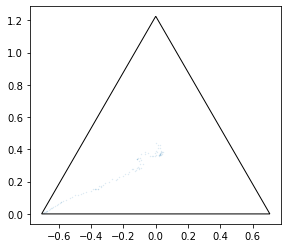

<Figure size 720x720 with 0 Axes>

In [84]:
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(path)
plt.scatter(X[0:200000,0], X[0:200000,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

In [455]:
key, subkey = random.split(key)

random.dirichlet(key, alpha=jnp.ones(3), shape=(10000,))
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])

plt.figure()
#path = get_simplex_path(10_000, 2, key)
simp3_unif = random.dirichlet(key, alpha=jnp.ones(3), shape=(10000,))
X = batch_rotate(simp3_unif)
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.5)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.show()

NameError: name 'batch_rotate' is not defined

<Figure size 432x288 with 0 Axes>

In [53]:
jnp.array([2, 3, 4, 5])**2

DeviceArray([ 4,  9, 16, 25], dtype=int32)

In [315]:
from jax import jacfwd, jacrev

sfm = jax.nn.softmax

jacfwd(jacrev(sfm))(jnp.array([1., 1., 1.]))

DeviceArray([[[ 0.07407409, -0.03703704, -0.03703704],
              [-0.03703704, -0.03703704,  0.07407407],
              [-0.03703704,  0.07407407, -0.03703704]],

             [[-0.03703704, -0.03703704,  0.07407407],
              [-0.03703704,  0.07407409, -0.03703704],
              [ 0.07407407, -0.03703704, -0.03703704]],

             [[-0.03703704,  0.07407407, -0.03703704],
              [ 0.07407407, -0.03703704, -0.03703704],
              [-0.03703704, -0.03703704,  0.07407409]]], dtype=float32)

In [335]:

#key = jax.random.PRNGKey(34)

key, subkey = jax.random.split(key)

inds = jax.random.choice(subkey, 3, (3,), replace=False)


abc = jnp.array([10, 11, 12]) 
print(inds)
print(abc[inds])
    

[2 0 1]
[12 10 11]


In [423]:
key, subkey = jax.random.split(key)
jax.random.choice(subkey, 2, (1,), p=jnp.array([.8, .2]))

DeviceArray([1], dtype=int32, weak_type=True)

In [333]:
x = jnp.array([2., 3., 4.])
i = 1
j = 2

def same_ind(i, j, x):
        return x[i] * (1. - x[i])

def diff_ind(i, j, x):
    return -1. * x[i] * x[j]
jax.lax.cond(i == j, same_ind, diff_ind, i, j, x)

DeviceArray(-12., dtype=float32)

In [79]:
dist = 1 - x1.sum()


tensor(0.8000)

In [80]:
z = torch.zeros((3,))

In [81]:
z

tensor([0., 0., 0.])

In [85]:
z.index_add_(0, torch.tensor([1, 2]), torch.tensor([2., 2.]))


tensor([0., 2., 2.])

In [90]:
z = torch.tensor([1., 2., 3., 4.])
torch.tile(z, (3, 1))

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])

In [92]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [131]:
from torchtyping import TensorType

def cube_to_simplex_project(x: TensorType['batch', -1]):
    assert torch.all(x >= 0) and torch.all(x <= 1)
    lambda_0 = torch.mean(1 - x, dim=1)
    x_0 = 
    # black magic
    # more seriously, example, goes from tensor with shape (batch, dim) such as
    # the 3x2 tensor [[.19, .61], [.61, .65], [.8, .05]] to  (batch, dim, dim) 3x2x2
    # [[[0.1900, 0.6100],
    #   [0.1900, 0.6100]],
    #  [[0.6100, 0.6500],
    #   [0.6100, 0.6500]],
    #  [[0.8000, 0.0500],
    #   [0.8000, 0.0500]]]
    many_xs = torch.tile(x[:, None], (1, x.shape[1], 1))
    dist_diags = torch.cat([torch.eye(x.shape[-1])[None] * d for d in dist_to_simplex])
    return torch.mean(dist_diags + many_xs, dim=1)

In [123]:
torch.tile(x[:,None], (1, 2, 1))

tensor([[[0.1900, 0.6100],
         [0.1900, 0.6100]],

        [[0.6100, 0.6500],
         [0.6100, 0.6500]],

        [[0.8000, 0.0500],
         [0.8000, 0.0500]]])

In [119]:
torch.tile(x, (1, x.shape[-1]))

tensor([[0.1900, 0.6100, 0.1900, 0.6100],
        [0.6100, 0.6500, 0.6100, 0.6500],
        [0.8000, 0.0500, 0.8000, 0.0500]])

In [125]:
(1 - x.sum(1)).tolist()

[0.19999998807907104, -0.25999999046325684, 0.1499999761581421]

In [141]:
x = torch.rand((1, 3))
cube_to_simplex_project(x)

tensor([[-0.2162,  0.6114,  0.6048]])

In [142]:
x

tensor([[0.0474, 0.8751, 0.8684]])

In [143]:
d = 1 - torch.sum(x, 1)
d

tensor([-0.7909])

In [336]:
jax.random.uniform(subkey, (1,))

DeviceArray([0.5975504], dtype=float32)